<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTACOES, CARREGAMENTO E MODELOS

In [ ]:
#!pip install d2l==0.16.2
#!pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

train_data = pd.read_csv('https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/datasets/houseofprices.train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/datasets/houseofprices.test.csv')

# Remove o ID
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# Todos os valores NÚMERICOS em branco são adicionados com a média da coluna
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply( lambda x: (x - x.mean()) / (x.std()))

# Os resto dos valores em branco são inseridos como 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# Caso possua algum valor em branco o get_dummies transforma como um valor válido
all_features = pd.get_dummies(all_features, dummy_na=True)

# Numero de colunas para o treinamento
n_train = train_data.shape[0]

# Separação dos dados de treino, teste e separa os rótulos para depois ser avaliado
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# Valores dos campos da rede
in_features = train_features.shape[1]

loss_1 = nn.MSELoss()

def get_net_1():
  net = nn.Sequential(nn.Linear(in_features, 1))
  return net

def get_net_2(hidden_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Linear(hidden_size, hidden_size), nn.Linear(hidden_size, 1))
  return net

def get_net_3(hidden_size, dropout_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Dropout(dropout_size), nn.Linear(hidden_size, hidden_size), nn.Dropout(dropout_size), nn.Linear(hidden_size, 1))
  return net

def get_net_4(hidden_size, dropout_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Dropout(dropout_size), nn.Linear(hidden_size, 12), nn.Sigmoid(), nn.Linear(hidden_size, 1))
  return net

def get_net_5(hidden_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Sigmoid(), nn.Linear(hidden_size, 12), nn.Sigmoid(), nn.Linear(hidden_size, 1))
  return net

def get_net_6(hidden_size, dropout_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Dropout(dropout_size), nn.Linear(hidden_size, 12), nn.ReLU(), nn.Linear(hidden_size, 1))
  return net

def get_net_7(hidden_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.Sigmoid(), nn.Linear(hidden_size, 12), nn.ReLU(), nn.Linear(hidden_size, 1))
  return net

def get_net_8(hidden_size):
  net = nn.Sequential(nn.Linear(in_features, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 12), nn.ReLU(), nn.Linear(hidden_size, 1))
  return net

def log_rmse(net, features, labels, loss_active):
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss_active(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size, loss_active):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss_active(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels, loss_active))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels, loss_active))
  return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size, get_net, loss_active):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size, loss_active)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
    print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, 'f'valid log rmse {float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

## AVALIACOES

fold 1, train log rmse 0.149510, valid log rmse 0.146897
fold 2, train log rmse 0.145150, valid log rmse 0.162651
fold 3, train log rmse 0.143237, valid log rmse 0.149784
fold 4, train log rmse 0.148384, valid log rmse 0.145597
fold 5, train log rmse 0.143305, valid log rmse 0.173440
5-fold validation: avg train log rmse: 0.145917, avg valid log rmse: 0.155674
|----------------------------------------|
fold 1, train log rmse 0.143674, valid log rmse 0.148612
fold 2, train log rmse 0.144445, valid log rmse 0.140617
fold 3, train log rmse 0.138686, valid log rmse 0.173134
fold 4, train log rmse 0.137706, valid log rmse 0.162961
fold 5, train log rmse 0.146215, valid log rmse 0.122780
fold 6, train log rmse 0.140945, valid log rmse 0.161534
fold 7, train log rmse 0.141884, valid log rmse 0.171451
7-fold validation: avg train log rmse: 0.141936, avg valid log rmse: 0.154441
|----------------------------------------|
fold 1, train log rmse 0.341462, valid log rmse 0.163872
fold 2, train log

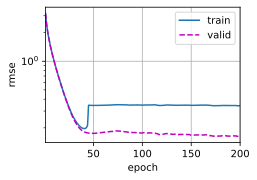

In [ ]:
k = [5, 7, 9]
num_epochs = [100, 150, 200]
lr = [5, 10, 15]
weight_decay = [0, 0.1, 0.5]
batch_size = [32, 64, 128]

train_l, valid_l = k_fold(k[0], train_features, train_labels, num_epochs[0], lr[0], weight_decay[0], batch_size[0], get_net_1, loss_1)
print(f'{k[0]}-fold validation: avg train log rmse: {float(train_l):f}, 'f'avg valid log rmse: {float(valid_l):f}')
print('|----------------------------------------|')
train_l, valid_l = k_fold(k[1], train_features, train_labels, num_epochs[1], lr[1], weight_decay[1], batch_size[1], get_net_1, loss_1)
print(f'{k[1]}-fold validation: avg train log rmse: {float(train_l):f}, 'f'avg valid log rmse: {float(valid_l):f}')
print('|----------------------------------------|')
train_l, valid_l = k_fold(k[2], train_features, train_labels, num_epochs[2], lr[2], weight_decay[2], batch_size[2], get_net_1, loss_1)
print(f'{k[2]}-fold validation: avg train log rmse: {float(train_l):f}, 'f'avg valid log rmse: {float(valid_l):f}')
print('|----------------------------------------|')